In [1]:
from torchvision import datasets
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import numpy as np
import torchvision.utils as vutils
import PIL.Image as Image
import matplotlib.pyplot as plt
torch.cuda.is_available()
from torchsummary import summary
import seaborn as sns

In [2]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
 
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
 
# DataLoader is used to load the dataset 
# for training
labels = [1, 2, 3, 4, 5]
indices = [idx for idx, target in enumerate(dataset.targets) if target in labels]
loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, indices),
                                     batch_size = 32,
                                     shuffle = True)

In [3]:
len(loader)

941

In [4]:
# Define the Autoencoder model with Conv2d layers and a bottleneck (nn.Linear)
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 30),  # Bottleneck layer with reduced dimensionality
            nn.ReLU(),
            nn.Linear(30, 64 * 4 * 4),  # Bottleneck layer with reduced dimensionality
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=2, output_padding=1),
            nn.Tanh()  # Output values between -1 and 1 (suitable for images)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x.view(x.size(0), 64, 4, 4))  # Reshape for decoding
        return x

In [5]:
epochs = 30
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

model = AutoEncoder().to(device)

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           4,640
              ReLU-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
              ReLU-6             [-1, 64, 4, 4]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                   [-1, 30]          30,750
              ReLU-9                   [-1, 30]               0
           Linear-10                 [-1, 1024]          31,744
             ReLU-11                 [-1, 1024]               0
  ConvTranspose2d-12             [-1, 32, 8, 8]          18,464
             ReLU-13             [-1, 32, 8, 8]               0
  ConvTranspose2d-14           [-1, 16,

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)# Train
model.train()
log_loss=[]
for epoch in range(epochs):
    total_loss = 0
    for data, _ in loader:
        inputs = data.to(device) 
        
        model.zero_grad()
        
        decoded = model(inputs)
        loss = loss_function(decoded, inputs)
        loss.backward()
        
        optimizer.step()
        
        total_loss+=loss
        log_loss.append(loss)
    total_loss /= len(loader.dataset)
    
    if epoch % 5 ==0:
        print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

[1/30] Loss: 0.0008485839935019612
[6/30] Loss: 0.0003285144339315593
[11/30] Loss: 0.00028532478609122336
[16/30] Loss: 0.00026393032749183476
[21/30] Loss: 0.0002513235085643828
[26/30] Loss: 0.000242426001932472
[30/30] Loss: 0.00023702569887973368


In [7]:
torch.save(model, 'mode_AutoEncoder_MNIST_Encoder5.pth')

In [8]:
test_dataset = datasets.MNIST('./data', train=False, download=True, transform= transforms.ToTensor())

# Exclude Label 5 Test 
labels_t1 = [1, 2, 3, 4, 5]
indices_t1 = [idx for idx, target in enumerate(test_dataset.targets) if target in labels_t1]
loader_t1 = torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataset, indices_t1),
                                     batch_size = 1,
                                     shuffle = True)

# Label 5 
labels_t2 = [6, 7, 8, 9, 0]
indices_t2 = [idx for idx, target in enumerate(test_dataset.targets) if target in labels_t2]
loader_t2 = torch.utils.data.DataLoader(torch.utils.data.Subset(test_dataset, indices_t2),
                                     batch_size = 1,
                                     shuffle = True)

print(len(loader_t1))
print(len(loader_t2))

5051
4949


In [9]:
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')# Load model

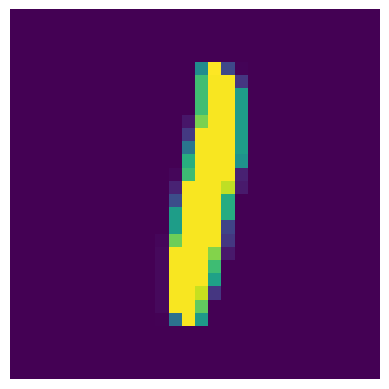

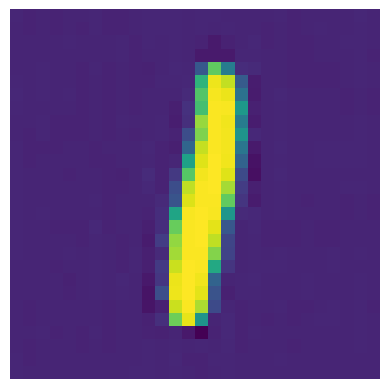

0.008018636144697666


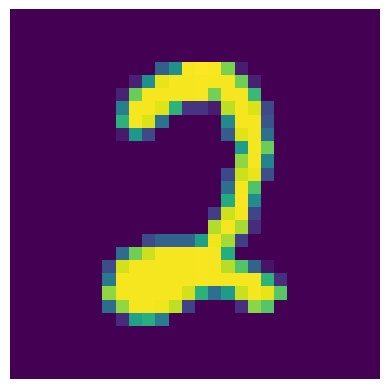

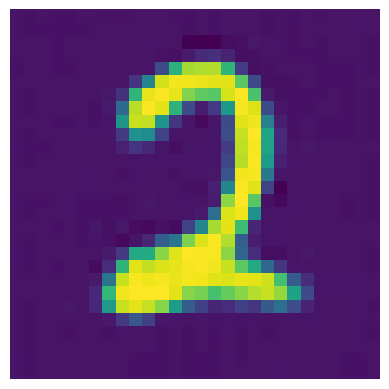

0.0013812507968395948


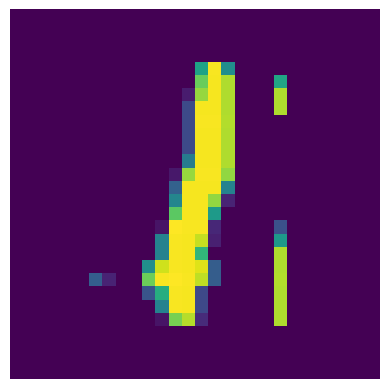

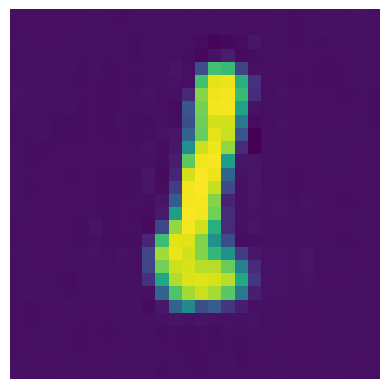

0.006842826027423143


In [10]:
criterion = nn.MSELoss()
loss_exclude_dist_arr = []
model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(loader_t1):
        inputs = data.to(device)
        # Forward
        model.zero_grad()
        
        decoded = model(inputs)

        if i<3:
            show_images(inputs.detach().cpu())
            plt.show()# Forward
    
            show_images(decoded.detach().cpu())
            plt.show()# Forward
            
            print(loss.item()) 
        
        
        loss = criterion(inputs.to(device), decoded)
        loss_exclude_dist_arr.append(loss.item())

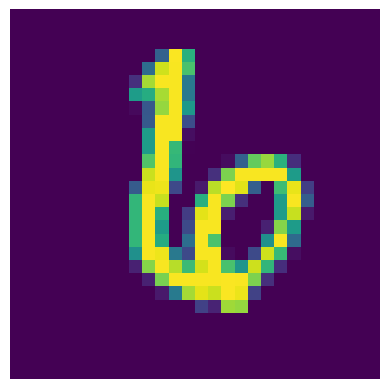

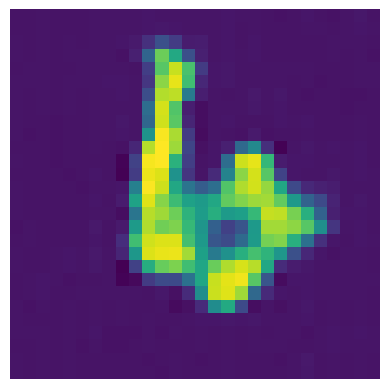

0.008110425435006618


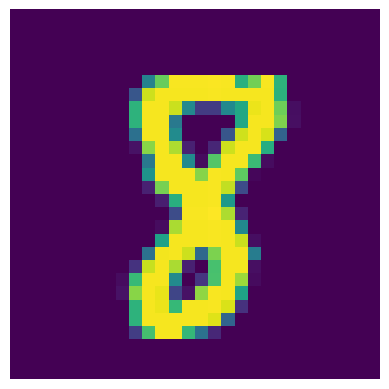

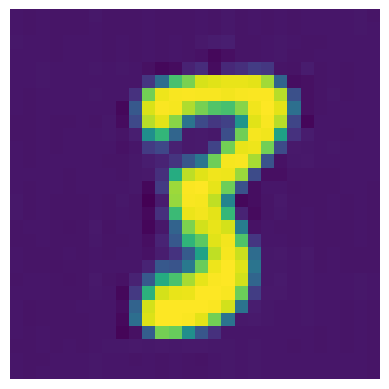

0.03314511105418205


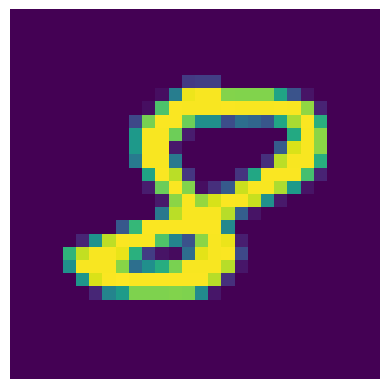

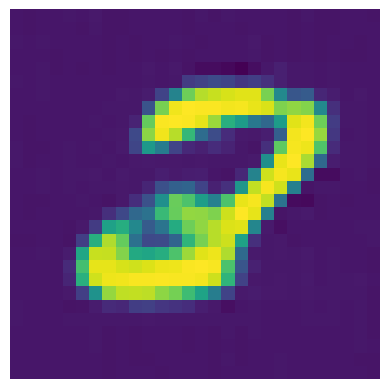

0.02788018062710762


In [11]:
criterion = nn.MSELoss()
loss_anomaly_dist_arr = []
model.eval()
with torch.no_grad():
    for i, (data, target) in enumerate(loader_t2):
        inputs = data.to(device)
        # Forward
        model.zero_grad()
        
        decoded = model(inputs)

        if i<3:
            show_images(inputs.detach().cpu())
            plt.show()# Forward
    
            show_images(decoded.detach().cpu())
            plt.show()# Forward
            
            print(loss.item())        
        
        loss = criterion(inputs.to(device), decoded)
        loss_anomaly_dist_arr.append(loss.item())

In [12]:
len(loss_exclude_dist_arr)

5051

In [13]:
len(loss_anomaly_dist_arr)

4949

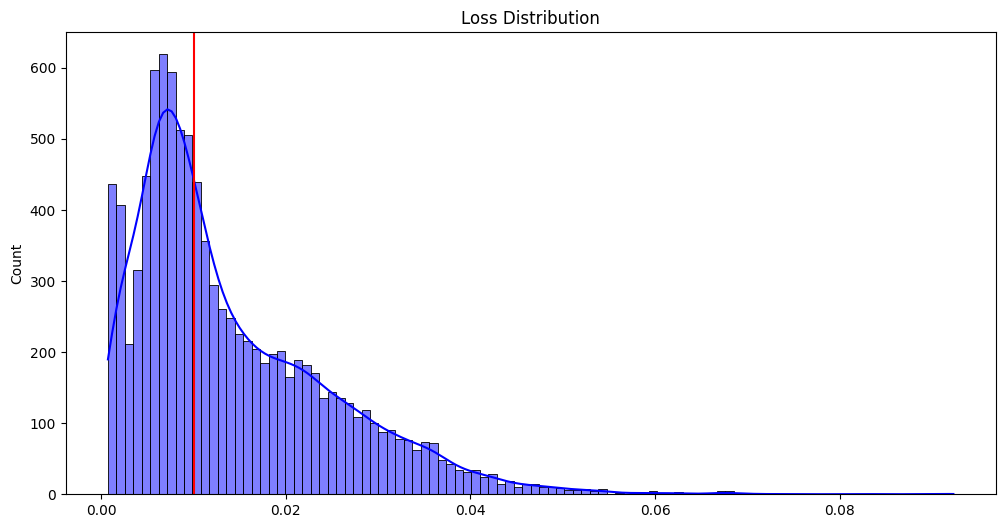

In [26]:
# Validation
all_test_loss = loss_exclude_dist_arr + loss_anomaly_dist_arr
len(all_test_loss)
threshold = 0.01

plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.histplot(all_test_loss, bins=100,kde=True, color='blue')
plt.axvline(threshold, 0.0, 10, color='r')

In [27]:
tp = 0
fp = 0
tn = 0
fn = 0

# Anomaly detection: true positive: it is anomaly and it is detected as anomaly
for i, v in enumerate(loss_anomaly_dist_arr):
    if v >= threshold:
        tp += 1
    else:
        fp += 1

for i, v in enumerate(loss_exclude_dist_arr):
    if v < threshold:
        tn += 1
    else:
        fn += 1

print('[TP] {}\t[FP] {}\t'.format(tp, fp))
print('[TN] {}\t[FN] {}'.format(tn, fn))

[TP] 4050	[FP] 899	
[TN] 3797	[FN] 1254


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

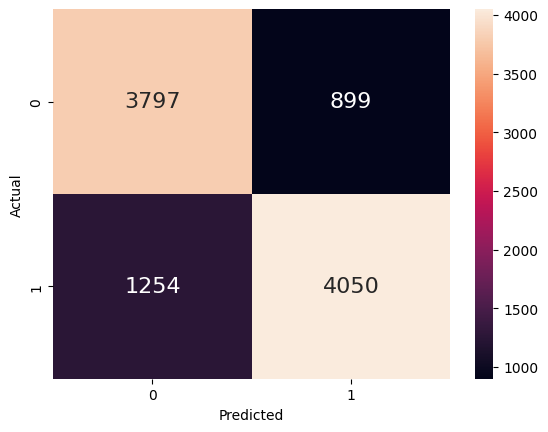

In [28]:
conf = [[tn,fp],[fn,tp]]
plt.figure()
s = sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')
s.set(xlabel='Predicted', ylabel='Actual')

In [29]:
precision=tp/(tp+fp)
recall=tp/(tp+fn)
f1=2*precision*recall/(precision+recall)
print('precision {}'.format(precision))
print('recall {}'.format(recall))
print('f1 Score {}'.format(f1))

precision 0.8183471408365326
recall 0.7635746606334841
f1 Score 0.7900126792158392
